# Importar las librerías

In [ ]:
# Instalamos las librerias para exportar el modelo
!pip install pyyaml h5py
!pwd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/Apuntes/7mo semestre/BootSandalShow


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Conectando con drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Apuntes/7mo semestre/BootSandalShow"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Apuntes/7mo semestre/BootSandalShow


# Definición de parametros

In [ ]:
batch = 128
img_height = 100
img_width = 100
data_dir = os.getcwd()
data_dir

'/content/drive/MyDrive/Apuntes/7mo semestre/BootSandalShow'

# Cargando el dataset
Cargamos el dataset y dejamos un 20% de los datos para validación

In [ ]:
# Creamos el set de entrenamiento
train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size=batch
)

Found 15001 files belonging to 3 classes.
Using 12001 files for training.


In [ ]:
# Creamos el set de validación
validation = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset= 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch
)

Found 15001 files belonging to 3 classes.
Using 3000 files for validation.


Estos son los nombres de las clases

In [ ]:
class_names = train.class_names
print(class_names)

['Boot', 'Sandal', 'Shoe']


Vamos a visualizar el conjunto de datos

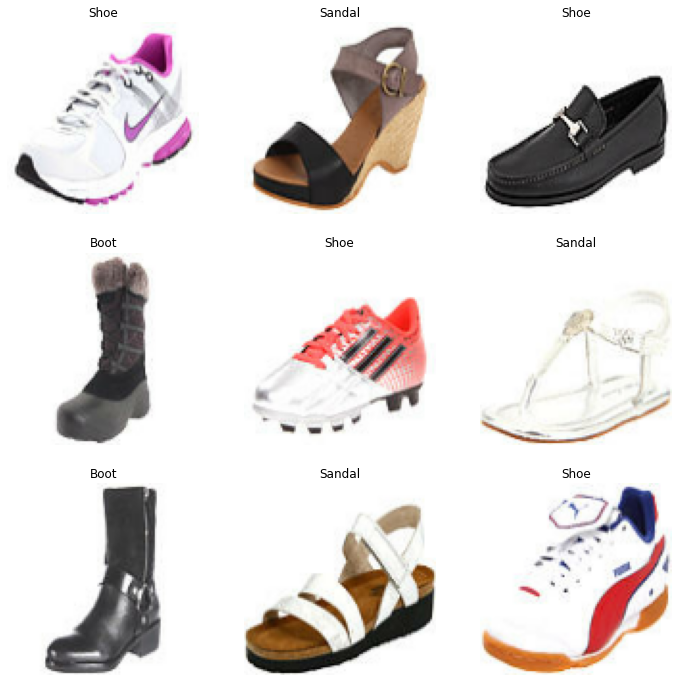

In [ ]:
plt.figure(figsize=(12,12))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

Vemos las dimensiones de nuestras iamgenes

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 100, 100, 3)
(128,)


# Sobre el dataset

El dataset está conformado por 3 clases: Shoe, Sandal y Boot. Cada clase tiene un conjunto de 5000 imágenes, así no tendremos problemas de desbalanceo de clases.
Cada imagen tiene 3 canales ya que viene en RGB y tienen un tamaño de 100x100 pixeles.
Se puede conseguir el dataset completo [aquí](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images).

#Configurando el dataset
Necesitamos configurar nuestro dataset para obtener los datos desde el búfer del disco y evitar un bloqueo durante la escritura o lectura.

Usaremos Dataset.cache para mantener las imágenes en la memoria después de la primera época para evitar un cuello de botella durante el entrenamiento.
También usaremos Dataset.prefetch para superponer el procesamiento de datos y la ejecución del modelo mientras entrenamos el modelo.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation.cache().prefetch(buffer_size=AUTOTUNE)

# Creación del modelo
Vamos realizar un modelo convolutivo secuencial con una primera capa de rescaling para normalizar nuestros datos de entrada del rango de 0-255 a 0-1, tres bloques de convolución 2D, 3 capas de maxpooling2d utilizando la activación 'relu' para que la red neuronal pueda encontrar patrones en las imágenes, una capa de flatten para cambiar las dimensiones de la imagen, una capa densa de 256 neuronas y la siguiente con la cantidad de neuronas equivalente al número de clases que tenemos. 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

# Compilando el modelo
Para este modelo vamos a utilizar el optimizador Adam y la función de pérdida sparse categorical cross-entropy y un learning rate de 0.00001

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 25, 64)       

Como vemos, nuestro modelo nos dice que tenemos más de 1,500,000 parámetros entrenables. Debemos tener cuidado de que estos parámetros no hagan overfit.

#Entrenando el modelo
Vamos a entrenar el modelo con 10 épocas para tratar de no caer en overfitting.

In [ ]:
epochs = 10
history = model.fit(
  train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/10
94/94 [==============================] - 19s 184ms/step - loss: 0.9852 - accuracy: 0.6552 - val_loss: 0.8634 - val_accuracy: 0.7753
Epoch 2/10
94/94 [==============================] - 19s 192ms/step - loss: 0.7432 - accuracy: 0.7749 - val_loss: 0.6238 - val_accuracy: 0.7830
Epoch 3/10
94/94 [==============================] - 18s 178ms/step - loss: 0.5571 - accuracy: 0.8124 - val_loss: 0.4834 - val_accuracy: 0.8557
Epoch 4/10
94/94 [==============================] - 19s 189ms/step - loss: 0.4614 - accuracy: 0.8418 - val_loss: 0.4140 - val_accuracy: 0.8697
Epoch 5/10
94/94 [==============================] - 19s 185ms/step - loss: 0.4036 - accuracy: 0.8653 - val_loss: 0.3676 - val_accuracy: 0.8780
Epoch 6/10
94/94 [==============================] - 18s 182ms/step - loss: 0.3667 - accuracy: 0.8778 - val_loss: 0.3355 - val_accuracy: 0.8863
Epoch 7/10
94/94 [==============================] - 18s 180ms/step - loss: 0.3376 - accuracy: 0.8871 - val_loss: 0.3122 - val_accuracy: 0.8923

Tenemos una exactitud muy buena del 90%. Vamos a ver gráficamente los resultados entre el validation accuracy y el accuracy.

# Visualizando los resultados del entrenamiento

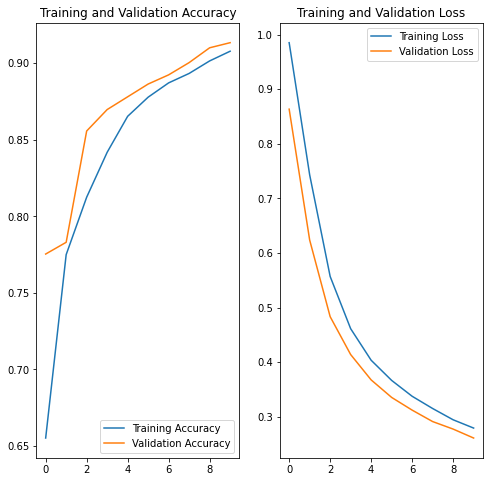

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como podemos ver, nuestro validation accuracy y nuestro validation loss están muy cercanos a nuestro training accuracy y nuestro training loss. Esto nos indica que es posible que no hayamos caído en overfitting y nuestro modelo generaliza bien. Vamos a ver qué tal se desempeña.

# Predicción con datos no vistos

In [ ]:
from uuid import uuid4
from time import sleep
# Botas
# Botas
botas = [
    "https://m.media-amazon.com/images/I/71zPHz0WzVL._AC_SY695_.jpg",
    "https://sieteleguas.mx/3156-home_default/bota-roper-siete-leguas-track-en-piel-crazy-cafe-est-1000.jpg",
    "http://cdn.shopify.com/s/files/1/0093/2144/7505/products/Alamo_Miel-Lateral1_1.jpg?v=1637171538",
    "http://cdn.shopify.com/s/files/1/0241/9654/6624/products/cypress-black_grande.jpg?v=1664358198"
]

# Sandalias
sandalias = [
    "https://ss550.liverpool.com.mx/sm/1111898281.jpg",
    "https://res.cloudinary.com/walmart-labs/image/upload/d_default.jpg/w_960,dpr_auto,f_auto,q_auto:best/gr/images/product-images/img_large/00750120630865L.jpg",
    "https://cdn1.coppel.com/images/catalog/pr/8246302-1.jpg",
    "https://ss550.liverpool.com.mx/sm/1118218430.jpg"
]

# Tenis
tenis = ["https://dsnegsjxz63ti.cloudfront.net/images/pg/g_326057f0f6d6ee2.jpg",
         "https://media.vogue.mx/photos/5c070382a5382b140c0efb1e/master/w_1800,h_1201,c_limit/los_10_tenis_mas_iconicos_que_te_duraran_toda_la_vida_imagenes_278478343.jpg"
         "https://dpjye2wk9gi5z.cloudfront.net/wcsstore/ExtendedSitesCatalogAssetStore/images/catalog/default/1023869-0001V1.jpg",
         "https://media.vogue.mx/photos/5c070382a5382b140c0efb1e/master/w_1800,h_1201,c_limit/los_10_tenis_mas_iconicos_que_te_duraran_toda_la_vida_imagenes_278478343.jpg",
         "https://images.puma.com/image/upload/f_auto,q_auto,b_rgb:fafafa,w_480,h_480/global/384692/07/sv01/fnd/MEX/fmt/png/"]

tests = botas + sandalias + tenis
names = [['boot'] * len(botas),['sandal'] * len(sandalias), ['shoe'] * len(tenis)]
names = [item for sublist in names for item in sublist]
total = len(tests)
i = 0
for url in tests:
  name = uuid4()
  try:
    path = tf.keras.utils.get_file(str(name), origin=url)
    img = tf.keras.utils.load_img(
      path, target_size = (100, 100)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(
        "This image of a {} most likely belongs to {} with a {:.2f} percent confidence."
        .format(names[i], class_names[np.argmax(score)], 100 * np.max(score))
    )
    i += 1
  except Exception as e:
    print(e)
 
  

1/1 [==============================] - 0s 65ms/step
This image of a boot most likely belongs to Boot with a 92.36 percent confidence.
URL fetch failure on https://sieteleguas.mx/3156-home_default/bota-roper-siete-leguas-track-en-piel-crazy-cafe-est-1000.jpg: 404 -- Not Found
1/1 [==============================] - 0s 16ms/step
This image of a boot most likely belongs to Sandal with a 99.13 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image of a boot most likely belongs to Sandal with a 95.50 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image of a boot most likely belongs to Sandal with a 90.23 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image of a sandal most likely belongs to Sandal with a 76.51 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image of a sandal most likely belongs to Sandal with a 70.05 percent confidence.
1/1 [==============================] - 0

Nuestro modelo es relativamente bueno, sin embargo, se confunde con las sandalias y los tenis.

# Tratando de mejorar el modelo
Como podemos ver anteriormente, nuestro modelo clasifica todo como sandalias.
Vamos a intentar mejorar el modelo cambiando hiperparámetros y modificando la arquitectura

Vamos a añadir a la arquitectura dos capas de data augmentation: 
* Una capa de "volteo" de la imagen de forma aleatoria
* Una capa de rotación aleatoria.

También añadimos una capa de Dropout con un 20% de dropout justo antes de la última capa densa de 256 neuronas.

In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])


Después, cambiamos el learning rate por uno más grande de 0.00001 a 0.001

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 100, 100, 3)      0         
 tation)                                                         
                                                                 
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 16)       

Finalmente, vamos a cambiar las épocas de entrenamiento a 20 épocas.

In [ ]:
epochs = 20
history = model.fit(
  train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/20
94/94 [==============================] - 25s 250ms/step - loss: 0.8259 - accuracy: 0.6206 - val_loss: 0.4584 - val_accuracy: 0.8123
Epoch 2/20
94/94 [==============================] - 25s 258ms/step - loss: 0.4922 - accuracy: 0.7957 - val_loss: 0.4205 - val_accuracy: 0.8447
Epoch 3/20
94/94 [==============================] - 24s 239ms/step - loss: 0.3992 - accuracy: 0.8449 - val_loss: 0.2895 - val_accuracy: 0.8943
Epoch 4/20
94/94 [==============================] - 23s 238ms/step - loss: 0.3231 - accuracy: 0.8749 - val_loss: 0.2264 - val_accuracy: 0.9243
Epoch 5/20
94/94 [==============================] - 26s 270ms/step - loss: 0.2796 - accuracy: 0.8957 - val_loss: 0.1946 - val_accuracy: 0.9353
Epoch 6/20
94/94 [==============================] - 24s 247ms/step - loss: 0.2502 - accuracy: 0.9092 - val_loss: 0.1816 - val_accuracy: 0.9407
Epoch 7/20
94/94 [==============================] - 24s 245ms/step - loss: 0.2223 - accuracy: 0.9168 - val_loss: 0.1851 - val_accuracy: 0.9300

Graficamos

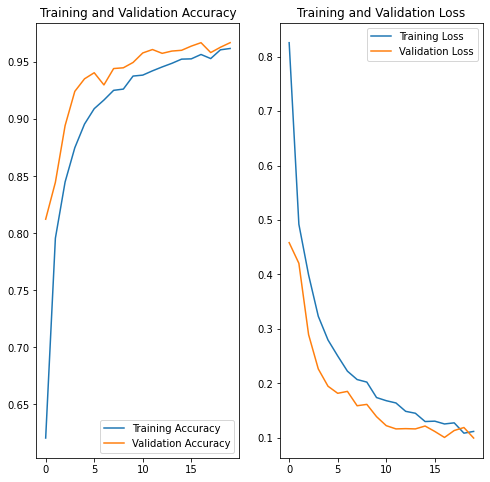

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Como podemos ver, nuestro accuracy de entrenamiento y el de validación terminaron muy cercanos entre ellos y muy cercanos a 1. Eso quiere decir que nuestro modelo es capaz de clasificar correctamente el 96% de las imágenes.
Ahora vamos a tratar nuevamente con datos no vistos.

In [ ]:
from time import sleep
# Botas
botas = [
    "https://m.media-amazon.com/images/I/71zPHz0WzVL._AC_SY695_.jpg",
    "https://sieteleguas.mx/3156-home_default/bota-roper-siete-leguas-track-en-piel-crazy-cafe-est-1000.jpg",
    "http://cdn.shopify.com/s/files/1/0093/2144/7505/products/Alamo_Miel-Lateral1_1.jpg?v=1637171538",
    "http://cdn.shopify.com/s/files/1/0241/9654/6624/products/cypress-black_grande.jpg?v=1664358198"
]

# Sandalias
sandalias = [
    "https://ss550.liverpool.com.mx/sm/1111898281.jpg",
    "https://res.cloudinary.com/walmart-labs/image/upload/d_default.jpg/w_960,dpr_auto,f_auto,q_auto:best/gr/images/product-images/img_large/00750120630865L.jpg",
    "https://cdn1.coppel.com/images/catalog/pr/8246302-1.jpg",
    "https://ss550.liverpool.com.mx/sm/1118218430.jpg"
]

# Tenis
tenis = ["https://dsnegsjxz63ti.cloudfront.net/images/pg/g_326057f0f6d6ee2.jpg",
         "https://media.vogue.mx/photos/5c070382a5382b140c0efb1e/master/w_1800,h_1201,c_limit/los_10_tenis_mas_iconicos_que_te_duraran_toda_la_vida_imagenes_278478343.jpg"
         "https://dpjye2wk9gi5z.cloudfront.net/wcsstore/ExtendedSitesCatalogAssetStore/images/catalog/default/1023869-0001V1.jpg",
         "https://media.vogue.mx/photos/5c070382a5382b140c0efb1e/master/w_1800,h_1201,c_limit/los_10_tenis_mas_iconicos_que_te_duraran_toda_la_vida_imagenes_278478343.jpg",
         "https://images.puma.com/image/upload/f_auto,q_auto,b_rgb:fafafa,w_480,h_480/global/384692/07/sv01/fnd/MEX/fmt/png/"]

tests = botas + sandalias + tenis
names = [['boot'] * len(botas),['sandal'] * len(sandalias), ['shoe'] * len(tenis)]
names = [item for sublist in names for item in sublist]
total = len(tests)
i = 0
for url in tests:
  name = uuid4()
  try:
    path = tf.keras.utils.get_file(str(name), origin=url)
    img = tf.keras.utils.load_img(
      path, target_size = (100, 100)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(
        "This {} is a {} with a {:.2f} percent confidence."
        .format(names[i], class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()
    i += 1
  except Exception as e:
    print(e)
 
  

1/1 [==============================] - 0s 70ms/step
This boot is a Boot with a 54.25 percent confidence.

URL fetch failure on https://sieteleguas.mx/3156-home_default/bota-roper-siete-leguas-track-en-piel-crazy-cafe-est-1000.jpg: 404 -- Not Found
1/1 [==============================] - 0s 18ms/step
This boot is a Boot with a 99.93 percent confidence.

1/1 [==============================] - 0s 17ms/step
This boot is a Sandal with a 66.94 percent confidence.

1/1 [==============================] - 0s 15ms/step
This boot is a Sandal with a 98.55 percent confidence.

1/1 [==============================] - 0s 16ms/step
This sandal is a Sandal with a 75.30 percent confidence.

1/1 [==============================] - 0s 21ms/step
This sandal is a Shoe with a 80.19 percent confidence.

1/1 [==============================] - 0s 14ms/step
This sandal is a Sandal with a 54.49 percent confidence.

1/1 [==============================] - 0s 15ms/step
This sandal is a Sandal with a 70.70 percent confi

# Conclusión de la mejora del modelo
Como podemos ver, el modelo aún se llega a confundir un poco, pero lo demás lo predice correctamente con un alto grado de seguridad.
El learning rate era muy bajo, por lo que el modelo estaba aprendiendo demasiado lento y poco a poco, lo que nos podía estar haciendo caer en un overfitting y haciendonos predecir erroneamente.

La capa de dropout nos permite que un 20% de neuronas aleatorias sean ignoradas durante el entrenamiento, lo que nos permitirá evitar el overfitting.

Finalmente, 20 épocas fueron justas para que el accuracy de entrenamiento y el de validación casi convergieran, evitando así que el modelo hiciera overfitting con los datos de entrenamiento o validación.


In [ ]:
# Para guardar el modelo.
# model.save("/content/drive/MyDrive/Apuntes/7mo semestre/")